# 📊 Forecasting with Darts – Workshop Notebook



## 1. Data Preparation
Let's start by loading a dataset.

<Axes: >

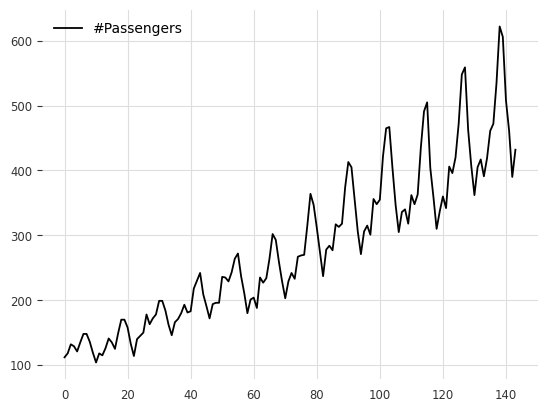

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from darts import TimeSeries

series = pd.read_csv('AirPassengers.csv')
series.plot()

## 2. Creating TimeSeries Objects
Darts uses the `TimeSeries` object. We can split it into train/validation sets.

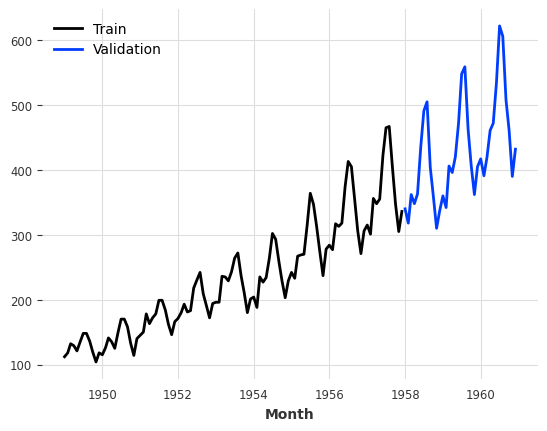

In [ ]:
series = TimeSeries.from_dataframe(series, "Month", "#Passengers") #To perform time operation

train, val = series[:-36], series[-36:]
train.plot(label='Train')
val.plot(label='Validation')
plt.legend()

## 3. Forecasting Models
We start with classical models such as **Exponential Smoothing** and **ARIMA**.

Exponential Smoothing:
- Forecasting method that predicts future values by taking the weighted average of past observation, with more weighting to recent data
- Simple Exponential Smoothing: best for data with no trend or seasonality.
- Holt’s and Holt-Winters methods extend it to handle trend and seasonality (additive or multiplicative).
- This is best for short forecasting

ARIMA (Auto Regressive Integrated Moving Average):
- Uses a linear combination of past value and past forecast error to predict the next value
- Seasonal ARIMA (SARIMA) extends ARIMA to handle repeating seasonal patterns.
- Not ideal for data with multiplicative seasonality or very noisy, unstable patterns.

When to use ARIMA vs Exponential:
- Exponential for a quick interpretable model, short term
- ARIMA for strong temporal dependenices (Current value are heavily influence by previous values so better when there are clear patterns)
- ARIMA requires series to be stationary

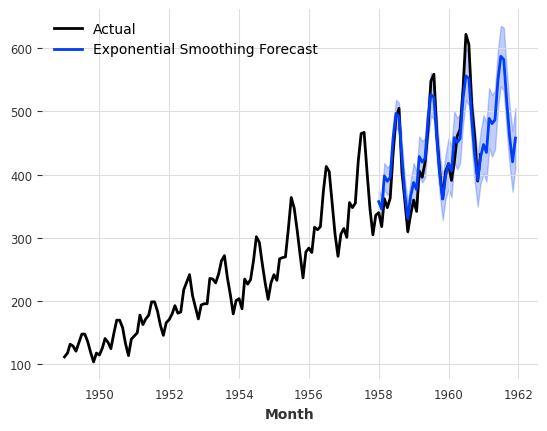

In [ ]:
from darts.models import ExponentialSmoothing

# Default to Holt WInter Exponential Smoothing
# Automatically fit the trend and seasonality
model = ExponentialSmoothing()
model.fit(train)
prediction = model.predict(len(val) + 12, num_samples=1000)
series.plot(label='Actual')
prediction.plot(label='Exponential Smoothing Forecast',  low_quantile = 0.05, high_quantile = 0.95)
plt.legend()

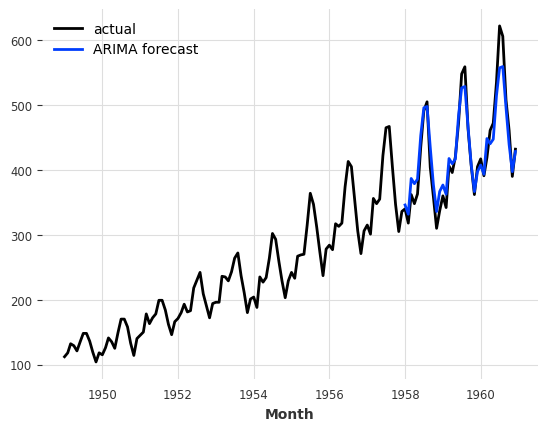

: 

In [ ]:
from darts.models import AutoARIMA

model_arima = AutoARIMA(season_length = 12)
model_arima.fit(train)
forecast_arima = model_arima.predict(len(val))
series.plot(label='actual')
forecast_arima.plot(label='ARIMA forecast')
plt.legend()

### Deep Learning Models (RNN - LSTM)
Darts also provides neural network models for forecasting.

RNN
- Create a memory of previous data, then look at the current input (month / passengers) to find the next output
- Works best with lot of data and can remember patterns across time
- Scaling is a must, and output are more black box

When to use LSTM:
- Best with data that doesn't have linear relationship
- Best with lots of data
- Can be used for multivariate inputs
- Better with Seasonality / Trend changes as it improve with new data / changing patterns

ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 2.8 K  | train
6 | V               | Linear           | 26     | train
-------------------------------------------------------------
2.8 K     Trainable params
0         Non-trainable params
2.8 K     Total params
0.011     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

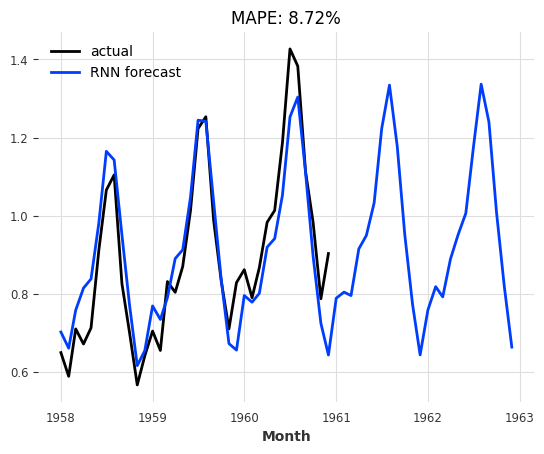

In [ ]:
from darts.models import RNNModel
from darts.metrics import mape
from darts.dataprocessing.transformers import Scaler

# Neural Network are sensitive to scaled data and helps with training
transformer = Scaler()
train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(val)
series_transformed = transformer.transform(series)

model_rnn = RNNModel(model='LSTM', input_chunk_length=12, output_chunk_length=1, n_epochs=1000, random_state=42)
model_rnn.fit(train_transformed, verbose=True)

forecast_rnn = model_rnn.predict(len(val_transformed)+24)

val_transformed.plot(label='actual')
forecast_rnn.plot(label='RNN forecast')
plt.title(f"MAPE: {mape(forecast_rnn, val_transformed):.2f}%")
plt.legend()
plt.show()

## 4. Model Evaluation & Backtesting
We use metrics like **MAPE** and Darts' built-in backtesting tools.

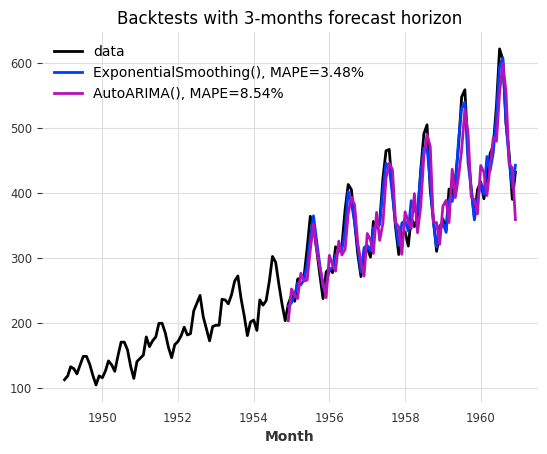

In [ ]:
models = [ExponentialSmoothing(), AutoARIMA()]

backtests = [model.historical_forecasts(series, start=.5) for model in models]

series.plot(label='data')
for i, m in enumerate(models):
    err = mape(backtests[i], series)
    backtests[i].plot(label='{}, MAPE={:.2f}%'.format(m, err))

plt.title('Backtests with 3-months forecast horizon')
plt.legend()

## 6. Advanced Features
- Model ensembling
- Hyperparameter tuning
-  Multivariate data

Explore these features in the [Darts documentation](https://unit8co.github.io/darts/).